In [1]:
import pandas as pd
import numpy as np
import qiime2 as q2

import biom
import h5py

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from qiime2.plugins import feature_table, diversity, greengenes2, taxa

## Metadata - General from LIBR

In [2]:
# diagnosis metadata from LIBR 
libr_md = pd.read_csv('../Updated_Data/DukeCollab_Metadata-9-22-2022.csv', index_col=0)

# medications metadata - ATC format 
medications = pd.read_csv('../Updated_Data/Tulsa_medications_ATC_v1.csv', 
                         encoding='unicode_escape', index_col=0)
medications = medications.loc[medications.atc.notna()]

# ATC medications of interest
atc_medication_key = ['C10_LipidReducingAgents', 'J01_Antibacterials',
                      'N05_Psycholeptics', 'N06_Psychoanaleptics', 
                      'N05A_Antipsychotics', 'N05B_Anxiolytics', 
                      'N05C_Hypnotics_and_Sedatives', 'N06A_Antidepressants', 
                      'N06B_Psychostimulants_for_ADHD_and_Nootropics', 
                      'N06D_AntiDementia_drugs']

for m in atc_medication_key:
    code = m.split('_')[0]
    users = medications.loc[medications.atc.str.startswith(code)]['id'].unique()
    libr_md.insert(libr_md.shape[1], m, np.where(libr_md.index.isin(users), 'True', 'False'))

## Metagenomics metadata cleaning

In [3]:
data_dir = '../Updated_Data/T1000Classic_Qiita10424/'

# metadata cleaning 
md_t1000c = q2.Metadata.load(data_dir + '10424_20230201-070656.txt')
md_t1000c_df = md_t1000c.to_dataframe()

md_t1000c_df['libr_id'] = [np.nan if 'BLANK' in i.upper() else i.split('.')[1].upper() for i in md_t1000c_df.index]
md_t1000c_df['cobre'] = np.where((md_t1000c_df['cobre'] != 'Yes') & (md_t1000c_df['libr_id'].notna()), 
                                 'No', md_t1000c_df['cobre'])
md_t1000c_df['cobre'].replace({'not applicable': np.nan, 'not provided': np.nan},
                              inplace=True)
md_t1000c_df['timepoint'] = np.where(md_t1000c_df.index.str.contains('1year'), '1year', 
                                     np.where(md_t1000c_df.libr_id.notna(), 'baseline', np.nan))

# remove non fecal samples
md_t1000c_fecal = md_t1000c_df.loc[md_t1000c_df.sample_type == 'feces']

# match to samples from LIBR
md_t1000c_libr = md_t1000c_fecal.loc[md_t1000c_fecal.libr_id.isin(libr_md.index)]

# save for qiime2 
md_t1000c_q2 = q2.Metadata(md_t1000c_libr)

In [14]:
final_t1000c_md_qiita = md_t1000c_df.reset_index().merge(libr_md[cols_to_include].reset_index(), how='left', 
                                                         left_on='libr_id', right_on='id').set_index('sample_name')
final_t1000c_md_qiita.drop(columns=['id'], inplace=True)
final_t1000c_md_qiita.to_csv('../Updated_Data/metadata_for_qiita.tsv', sep='\t')

## T1000 Classic Metagenomics Data (qiita ID 10424) 

In [4]:
# MetaG preps to merge 
metag_preps_paths = {
    'prep_16211': data_dir + 'MetaG/190163_none.biom',
    'prep_16212': data_dir + 'MetaG/190175_none.biom',
    'prep_16213': data_dir + 'MetaG/190178_none.biom',
    'prep_16214': data_dir + 'MetaG/190191_none.biom',
    'prep_16215': data_dir + 'MetaG/190247_none.biom'
}

# preps for Hg38 filtered data
'''
metag_preps_paths = {
    'prep_12718': data_dir + 'MetaG/156550_ft.qza',
    'prep_12719': data_dir + 'MetaG/156547_ft.qza',
    'prep_12720': data_dir + 'MetaG/156565_ft.qza',
    'prep_12721': data_dir + 'MetaG/156571_ft.qza',
    'prep_12722': data_dir + 'MetaG/156579_ft.qza'
}
'''

metag_preps = [q2.Artifact.import_data('FeatureTable[Frequency]', 
                                       metag_preps_paths[i]) for i in metag_preps_paths.keys()]
merged_wol2 = feature_table.methods.merge(tables=metag_preps, 
                                          overlap_method='sum').merged_table

# 16S preps to merge 
amp_preps_paths = {
    'prep_1428': data_dir + 'Amplicon/131547_feature-table.qza',
    'prep_2145': data_dir + 'Amplicon/128379_feature-table.qza',
    'prep_2569': data_dir + 'Amplicon/131073_feature-table.qza',
    'prep_4004': data_dir + 'Amplicon/128520_feature-table.qza',
    'prep_4607': data_dir + 'Amplicon/131180_feature-table.qza',
    'prep_4685': data_dir + 'Amplicon/130023_feature-table.qza', 
    'prep_6173': data_dir + 'Amplicon/132180_feature-table.qza', 
    'prep_7243': data_dir + 'Amplicon/132690_feature-table.qza', 
    'prep_8287': data_dir + 'Amplicon/133462_feature-table.qza'
}

preps_16s = [q2.Artifact.load(amp_preps_paths[i]) for i in amp_preps_paths.keys()]
merged_16s = feature_table.methods.merge(tables=preps_16s).merged_table

**All 16S Samples in Qiita 10424**

In [5]:
merged_16s.view(pd.DataFrame).loc[md_t1000c_df.index.intersection(merged_16s.view(pd.DataFrame).index)].shape

(4206, 97055)

**All fecal 16S samples**

In [6]:
merged_16s.view(pd.DataFrame).loc[md_t1000c_fecal.index.intersection(merged_16s.view(pd.DataFrame).index)].shape

(1440, 97055)

**All fecal 16S samples with matching LIBR ID**

In [7]:
merged_16s.view(pd.DataFrame).loc[md_t1000c_libr.index.intersection(merged_16s.view(pd.DataFrame).index)].shape

(1008, 97055)

In [8]:
merged_wol2.view(pd.DataFrame).shape

(321, 8209)

In [9]:
merged_wol2.view(pd.DataFrame).loc[md_t1000c_libr.index.intersection(merged_wol2.view(pd.DataFrame).index)].shape

(296, 8209)

## Filter to samples only present in LIBR 

In [10]:
table_metag = feature_table.methods.filter_samples(table=merged_wol2, 
                                                   metadata=md_t1000c_q2).filtered_table
table_16s = feature_table.methods.filter_samples(table=merged_16s, 
                                                 metadata=md_t1000c_q2).filtered_table
# also filter 16s to greengenes2 
gg2_tax = q2.Artifact.load('../Updated_Data/2022.10.taxonomy.asv.nwk.qza')
gg2_tree = q2.Artifact.load('../Updated_Data/2022.10.phylogeny.asv.nwk.qza')
table_16s = greengenes2.methods.filter_features(feature_table=table_16s, 
                                                reference=gg2_tree).filtered_feature_table
table_metag = greengenes2.methods.filter_features(feature_table=table_metag, 
                                                  reference=gg2_tree).filtered_feature_table

In [11]:
table_metag.view(pd.DataFrame).shape

(296, 6840)

In [12]:
print('Before removing duplicates: ' + str(table_16s.view(pd.DataFrame).shape))

def merge_with_libr(md_df):
    out = md_df.reset_index().merge(libr_md.reset_index(), left_on='libr_id', 
                                    right_on='id')
    dropped = out.drop(columns=['id']).set_index('index')
    
    for c in dropped.columns[dropped.columns.str.contains('DX_')]: 
        dropped[c] = dropped[c].astype('str')
    
    return dropped.rename_axis(index='SampleID')

# get dataframe representation of tables 
table_metag_df = table_metag.view(pd.DataFrame)
table_16s_df = table_16s.view(pd.DataFrame)

# remove duplicates from 16s 
md_t1000c_libr.insert(loc=md_t1000c_libr.shape[1], column='sequencing_depth', 
                      value=table_16s_df.sum(axis=1))
md_t1000c_libr = md_t1000c_libr.loc[md_t1000c_libr.sequencing_depth.notna()]
md_t1000c_sorted = md_t1000c_libr.sort_values('sequencing_depth', ascending=False)
md_t1000c_dedup = md_t1000c_sorted.loc[~md_t1000c_sorted.libr_id.duplicated()]
print('After removing duplicates: ' + 
      str(table_16s_df.loc[table_16s_df.index.intersection(md_t1000c_dedup.index)].shape))
md_t1000c_dedup = md_t1000c_dedup.loc[md_t1000c_dedup.sequencing_depth >= 5000]
print('After removing those with depth <5000: ' + 
      str(table_16s_df.loc[table_16s_df.index.intersection(md_t1000c_dedup.index)].shape))

# get separate metadata for metag and 16s 
metag_md = md_t1000c_libr.reindex(md_t1000c_libr.index.intersection(table_metag_df.index))
metag_md.drop(columns=['sequencing_depth'], inplace=True)
metag_md.insert(loc=metag_md.shape[1], column='sequencing_depth', 
                value=table_metag_df.sum(axis=1))
metag_md = merge_with_libr(metag_md)
metag_md = metag_md.loc[metag_md.sequencing_depth > 500000]
print('After removing those with depth <500000: ' + 
      str(table_16s_df.loc[table_metag_df.index.intersection(metag_md.index)].shape))

md_metag_q2 = q2.Metadata(metag_md)

md_16s = md_t1000c_dedup.reindex(md_t1000c_dedup.index.intersection(table_16s_df.index))
md_16s = merge_with_libr(md_16s)

# remove any samples that do not have DX_ANX, DX_MDD, or DX_HC 
md_16s = md_16s.loc[(md_16s['DX_ANX'] == 'True') | (md_16s['DX_MDD'] == 'True') | (md_16s['DX_HC'] == 'True')]
print('After only allowing MDD, ANX, & HC: ' + 
      str(table_16s_df.loc[table_16s_df.index.intersection(md_16s.index)].shape))

# remove any samples where J01_Antibacterials is True  
md_16s = md_16s.loc[md_16s['J01_Antibacterials'] == 'False']
print('After removing those on antibiotics: ' +
      str(table_16s_df.loc[table_16s_df.index.intersection(md_16s.index)].shape))

md_16s_q2 = q2.Metadata(md_16s)

libr_16s_filt = feature_table.methods.filter_samples(table=table_16s, 
                                                     metadata=md_16s_q2).filtered_table
libr_metag_filt = feature_table.methods.filter_samples(table=table_metag, 
                                                       metadata=md_metag_q2).filtered_table
print('Final: ' + str(libr_16s_filt.view(pd.DataFrame).shape))

Before removing duplicates: (1008, 18279)
After removing duplicates: (738, 18279)
After removing those with depth <5000: (704, 18279)
After removing those with depth <500000: (271, 18279)
After only allowing MDD, ANX, & HC: (700, 18279)
After removing those on antibiotics: (666, 18279)
Final: (666, 14062)


In [13]:
libr_metag_df = libr_metag_filt.view(pd.DataFrame)
libr_metag_df.index = [i + '.metag' for i in libr_metag_df.index]

libr_16s_df = libr_16s_filt.view(pd.DataFrame)
libr_16s_df.index = [i + '.16s' for i in libr_16s_df.index]

In [14]:
libr_full = pd.concat([libr_16s_df, libr_metag_df])
libr_full.replace({np.nan: 0}, inplace=True)

In [15]:
q2.Artifact.import_data('FeatureTable[Frequency]', libr_full).save('../Updated_Data/metag_16s_concat.qza')

'../Updated_Data/metag_16s_concat.qza'

In [16]:
md_16s_new = md_16s_q2.to_dataframe()
md_16s_new.index = [i + '.16s' for i in md_16s_new.index]
md_16s_new['data_layer'] = 'amplicon'

md_metag_new = md_metag_q2.to_dataframe()
md_metag_new.index = [i + '.metag' for i in md_metag_new.index]
md_metag_new['data_layer'] = 'WGS'

In [17]:
libr_md_full = pd.concat([md_16s_new, md_metag_new])
libr_md_full.to_csv('../Updated_Data/metag_16s_metadata.tsv', sep='\t')

In [18]:
md_16s['diagnosis_group'] = np.where(md_16s['DX_HC'] == 'True', 'HC', 
                                     np.where((md_16s['DX_MDD']=='True') & (md_16s['DX_ANX']=='True'), 'ANX&MDD', 
                                              np.where(md_16s['DX_MDD'] == 'True', 'MDD_Only', 'ANX_Only')))

md_16s['medication_group'] = np.where((md_16s['N05B_Anxiolytics'] == 'True') | 
                                      (md_16s['N06A_Antidepressants'] == 'True'), 'Antidepressant/Antianxiety', 
                                      np.where((md_16s['N05_Psycholeptics'] == 'True') | 
                                               (md_16s['N06_Psychoanaleptics'] == 'True') | 
                                               (md_16s['C10_LipidReducingAgents'] == 'True'), 'Other_Medication', 
                                               'Unmedicated'))

md_16s['medication_anxiolytics'] = np.where(md_16s['N05B_Anxiolytics'] == 'True', 'Anxiolytics', 
                                            np.where((md_16s['N05_Psycholeptics'] == 'True') | 
                                                     (md_16s['N06_Psychoanaleptics'] == 'True') | 
                                                     (md_16s['C10_LipidReducingAgents'] == 'True'), 
                                                     'Other_Medication', 'Unmedicated'))

md_16s['medication_antidepressants'] = np.where(md_16s['N06A_Antidepressants'] == 'True', 'Antidepressants', 
                                                np.where((md_16s['N05_Psycholeptics'] == 'True') | 
                                                         (md_16s['N06_Psychoanaleptics'] == 'True') | 
                                                         (md_16s['C10_LipidReducingAgents'] == 'True'), 
                                                        'Other_Medication', 'Unmedicated'))

In [19]:
metag_md['diagnosis_group'] = np.where(metag_md['DX_HC'] == 'True', 'HC', 
                                       np.where((metag_md['DX_MDD']=='True') & (metag_md['DX_ANX']=='True'), 'ANX&MDD', 
                                                np.where(metag_md['DX_MDD'] == 'True', 'MDD_Only', 'ANX_Only')))

metag_md['medication_group'] = np.where((metag_md['N05B_Anxiolytics'] == 'True') | 
                                        (metag_md['N06A_Antidepressants'] == 'True'), 'Antidepressant/Antianxiety', 
                                        np.where((metag_md['N05_Psycholeptics'] == 'True') | 
                                                 (metag_md['N06_Psychoanaleptics'] == 'True') | 
                                                 (metag_md['C10_LipidReducingAgents'] == 'True'), 'Other_Medication', 
                                                 'Unmedicated'))

metag_md['medication_anxiolytics'] = np.where(metag_md['N05B_Anxiolytics'] == 'True', 'Anxiolytics', 
                                              np.where((metag_md['N05_Psycholeptics'] == 'True') | 
                                                       (metag_md['N06_Psychoanaleptics'] == 'True') | 
                                                       (metag_md['C10_LipidReducingAgents'] == 'True'), 
                                                       'Other_Medication', 'Unmedicated'))

metag_md['medication_antidepressants'] = np.where(metag_md['N06A_Antidepressants'] == 'True', 'Antidepressants', 
                                                  np.where((metag_md['N05_Psycholeptics'] == 'True') | 
                                                           (metag_md['N06_Psychoanaleptics'] == 'True') | 
                                                           (metag_md['C10_LipidReducingAgents'] == 'True'), 
                                                           'Other_Medication', 'Unmedicated'))

In [20]:
libr_metag_filt.save('../Updated_Data/Medications_Data/metag_table_t2t.qza')
metag_md.to_csv('../Updated_Data/Medications_Data/metag_md.tsv', sep='\t')

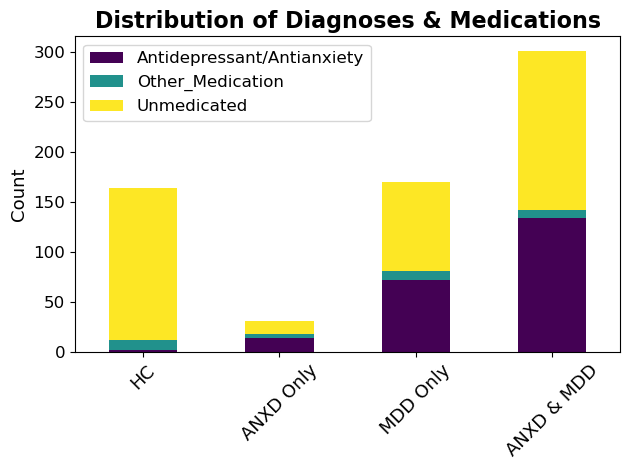

In [21]:
pivot_for_plot = md_16s.groupby('diagnosis_group')['medication_group'].value_counts().unstack()
reordered = pivot_for_plot.loc[['HC', 'ANX_Only', 'MDD_Only', 'ANX&MDD']]
reordered.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('')
plt.yticks(fontsize=12)
plt.ylabel('Count', fontsize=13)

ax=plt.gca()
ax.legend(title='', fontsize=12, prop={'size': 12})
ax.set_title('Distribution of Diagnoses & Medications', fontdict={'size':16, 'weight':'heavy'})
ax.set_xticklabels(['HC', 'ANXD Only', 'MDD Only', 'ANXD & MDD'], rotation=45, fontsize=13)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/distributions.png', transparent=True)

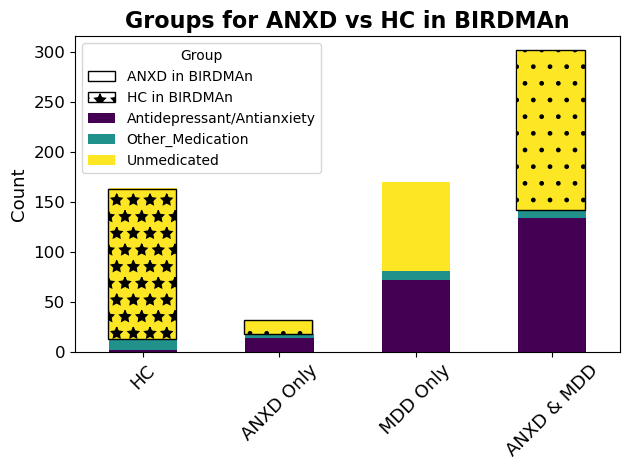

In [29]:
reordered.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('')
plt.ylabel('Count')
rectangle1 = patches.Rectangle((2.74, 142), 0.5, 160, edgecolor='k', facecolor='none', hatch='.', 
                               label='ANXD in BIRDMAn')
rectangle2 = patches.Rectangle((0.74, 18), 0.5, 14, edgecolor='k', facecolor='none', hatch='.')
rectangle3 = patches.Rectangle((-0.26, 13), 0.5, 150, edgecolor='k', facecolor='none', hatch='*', 
                               label='HC in BIRDMAn')

ax=plt.gca()
ax.add_patch(rectangle1)
ax.add_patch(rectangle2)
ax.add_patch(rectangle3)
ax.legend(title='Group')
ax.set_title('Groups for ANXD vs HC in BIRDMAn', fontdict={'size':16, 'weight':'heavy'})
ax.set_xticklabels(['HC', 'ANXD Only', 'MDD Only', 'ANXD & MDD'], rotation=45, fontsize=13)
plt.yticks(fontsize=12)
plt.ylabel('Count', fontsize=13)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig2a.pdf')

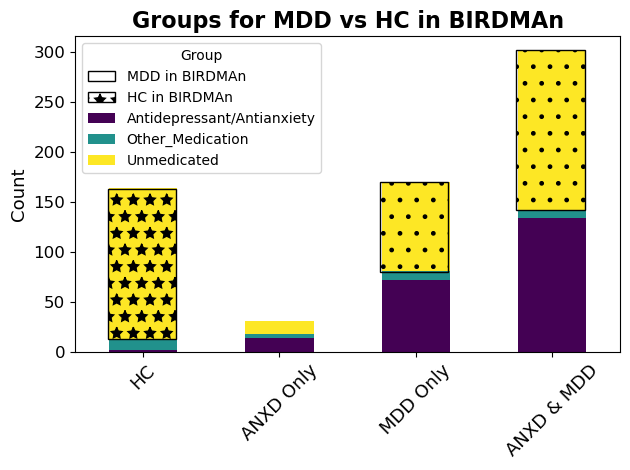

In [30]:
reordered.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('')
plt.ylabel('Count')
rectangle1 = patches.Rectangle((2.74, 142), 0.5, 160, edgecolor='k', facecolor='none', hatch='.', 
                               label='MDD in BIRDMAn')
rectangle2 = patches.Rectangle((-0.26, 13), 0.5, 150, edgecolor='k', facecolor='none', hatch='*', 
                               label='HC in BIRDMAn')
rectangle3 = patches.Rectangle((1.74, 80), 0.5, 90, edgecolor='k', facecolor='none', hatch='.')

ax=plt.gca()
ax.add_patch(rectangle1)
ax.add_patch(rectangle2)
ax.add_patch(rectangle3)
ax.legend(title='Group')
ax.set_title('Groups for MDD vs HC in BIRDMAn', fontdict={'size':16, 'weight':'heavy'})
ax.set_xticklabels(['HC', 'ANXD Only', 'MDD Only', 'ANXD & MDD'], rotation=45, fontsize=13)
plt.yticks(fontsize=12)
plt.ylabel('Count', fontsize=13)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig3a.pdf')

In [33]:
md_16s['diagnosis_group'].replace({'ANX_Only': 'ANXD Only', 'MDD_Only': 'MDD Only', 'ANX&MDD': 'ANXD & MDD'}, 
                                  inplace=True)

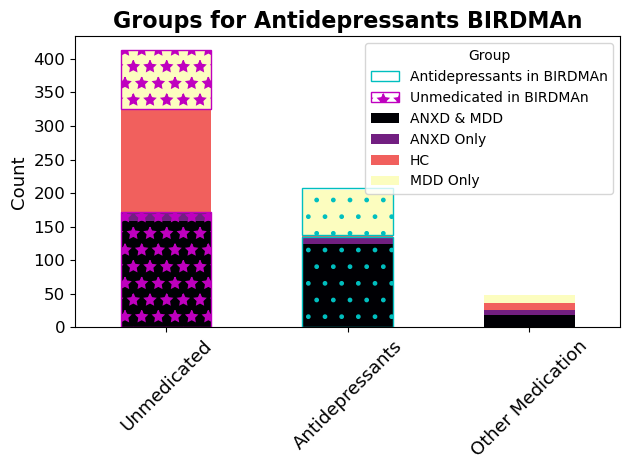

In [34]:
pivot_antid = md_16s.groupby('medication_antidepressants')['diagnosis_group'].value_counts().unstack()
reordered_antid = pivot_antid.loc[['Unmedicated', 'Antidepressants', 'Other_Medication']]
reordered_antid.plot(kind='bar', stacked=True, colormap='magma')

plt.ylabel('Count')
plt.xlabel('')

rectangle1 = patches.Rectangle((0.75, 137), 0.5, 70, edgecolor='c', facecolor='none', hatch='.', 
                               label='Antidepressants in BIRDMAn')
rectangle2 = patches.Rectangle((-0.25, 0), 0.5, 172, edgecolor='m', facecolor='none', hatch='*', 
                               label='Unmedicated in BIRDMAn')
rectangle3 = patches.Rectangle((-0.25, 325), 0.5, 88, edgecolor='m', facecolor='none', hatch='*')
rectangle4 = patches.Rectangle((0.75, 0), 0.5, 135, edgecolor='c', facecolor='none', hatch='.')

ax=plt.gca()
ax.add_patch(rectangle1)
ax.add_patch(rectangle2)
ax.add_patch(rectangle3)
ax.add_patch(rectangle4)

ax.legend(title='Group')
ax.set_xticklabels(['Unmedicated', 'Antidepressants', 'Other Medication'], rotation=45, fontsize=13)
plt.yticks(fontsize=12)
plt.ylabel('Count', fontsize=13)
ax.set_title('Groups for Antidepressants BIRDMAn', fontdict={'size':16, 'weight':'heavy'})
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig4d.pdf')

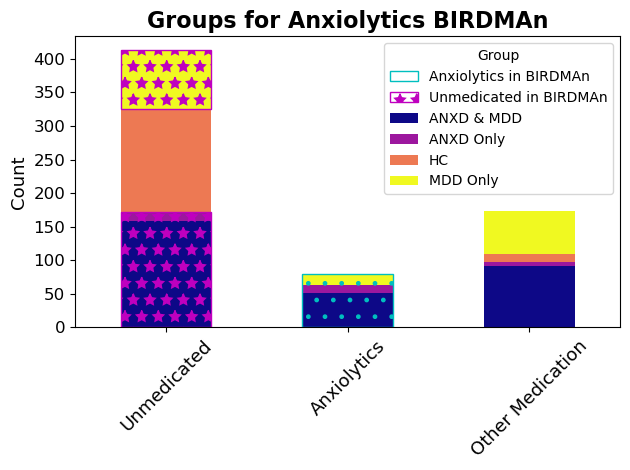

In [35]:
pivot_anx = md_16s.groupby('medication_anxiolytics')['diagnosis_group'].value_counts().unstack()
reordered_anx = pivot_anx.loc[['Unmedicated', 'Anxiolytics', 'Other_Medication']]
reordered_anx.plot(kind='bar', stacked=True, colormap='plasma')
plt.xlabel('Diagnostic Group')
plt.xlabel('')

rectangle1 = patches.Rectangle((0.75, 0), 0.5, 80, edgecolor='c', facecolor='none', hatch='.', 
                               label='Anxiolytics in BIRDMAn')
rectangle2 = patches.Rectangle((-0.25, 0), 0.5, 172, edgecolor='m', facecolor='none', hatch='*', 
                               label='Unmedicated in BIRDMAn')
rectangle3 = patches.Rectangle((-0.25, 325), 0.5, 88, edgecolor='m', facecolor='none', hatch='*')

ax=plt.gca()
ax.add_patch(rectangle1)
ax.add_patch(rectangle2)
ax.add_patch(rectangle3)

ax.legend(title='Group')
ax.set_xticklabels(['Unmedicated', 'Anxiolytics', 'Other Medication'], rotation=45, fontsize=13)
plt.yticks(fontsize=12)
plt.ylabel('Count', fontsize=13)
ax.set_title('Groups for Anxiolytics BIRDMAn', fontdict={'size':16, 'weight':'heavy'})
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig4a.pdf')

## Make tables

In [30]:
libr_16s_filt.save('../Updated_Data/final_tables/full_table.qza')

'../Updated_Data/final_tables/full_table.qza'

In [33]:
f = h5py.File('../Updated_Data/final_tables/full_table_classification.biom', 'w')
libr_16s_filt.view(biom.Table).to_hdf5(f, 'asd')
f.close()

In [31]:
libr_16s_rare = feature_table.methods.rarefy(table=libr_16s_filt,
                                             sampling_depth=5000).rarefied_table
#libr_16s_rare.save('../Updated_Data/final_tables/full_table_rarefied.qza')

In [32]:
# separate into medicated and unmedicated

unmedicated_md = md_16s.loc[md_16s['medication_group']=='Unmedicated']
medicated_md = md_16s.loc[md_16s['medication_group']=='Antidepressant/Antianxiety']

unmedicated_table = feature_table.methods.filter_samples(table=libr_16s_filt, 
                                                         metadata=q2.Metadata(unmedicated_md)).filtered_table
medicated_table = feature_table.methods.filter_samples(table=libr_16s_filt, 
                                                       metadata=q2.Metadata(medicated_md)).filtered_table

unmedicated_table.save('../Updated_Data/final_tables/unmedicated_table.qza')
medicated_table.save('../Updated_Data/final_tables/medicated_table.qza')

'''
unmedicated_table_rare = feature_table.methods.rarefy(table=unmedicated_table, 
                                                      sampling_depth=5000).rarefied_table
medicated_table_rare = feature_table.methods.rarefy(table=medicated_table, 
                                                    sampling_depth=5000).rarefied_table
'''

'\nunmedicated_table_rare = feature_table.methods.rarefy(table=unmedicated_table, \n                                                      sampling_depth=5000).rarefied_table\nmedicated_table_rare = feature_table.methods.rarefy(table=medicated_table, \n                                                    sampling_depth=5000).rarefied_table\n'

In [33]:
birdman_filt = md_16s.loc[(md_16s['Age'].notna()) & (md_16s['Gender'].notna()) & 
                          (md_16s['InBody_BMI'].notna()) & (md_16s['cobre'].notna())]
birdman_filt_table = feature_table.methods.filter_samples(table=libr_16s_filt, 
                                                          metadata=q2.Metadata(birdman_filt)).filtered_table

gg2_class_16s = greengenes2.methods.taxonomy_from_table(reference_taxonomy=gg2_tax, 
                                                        table=birdman_filt_table)
gg2_taxonomy_16s = gg2_class_16s.classification
gg2_taxonomy_16s.view(pd.DataFrame).to_csv('../Updated_Data/gg2_taxonomy_16s.csv')

#collapsed_birdman = taxa.methods.collapse(table=birdman_filt_table, taxonomy=gg2_taxonomy_16s, 
#                                          level=7).collapsed_table


gad_birdman = birdman_filt.loc[(birdman_filt['medication_group']=='Unmedicated') & 
                               (birdman_filt['diagnosis_group'] != 'MDD_Only')]
mdd_birdman = birdman_filt.loc[(birdman_filt['medication_group']=='Unmedicated') & 
                               (birdman_filt['diagnosis_group'] != 'GAD_Only')]

medication_birdman = birdman_filt.loc[(birdman_filt['medication_group']!='Other_Medication') & 
                                      (birdman_filt['diagnosis_group'] != 'HC')]

gad_birdman_table = feature_table.methods.filter_samples(table=birdman_filt_table, 
                                                         metadata=q2.Metadata(gad_birdman)).filtered_table
mdd_birdman_table = feature_table.methods.filter_samples(table=birdman_filt_table, 
                                                         metadata=q2.Metadata(mdd_birdman)).filtered_table
medication_birdman_table = feature_table.methods.filter_samples(table=birdman_filt_table, 
                                                                metadata=q2.Metadata(medication_birdman)).filtered_table



f = h5py.File('../Updated_Data/final_tables/gad_birdman_table.biom', 'w')
gad_birdman_table.view(biom.Table).to_hdf5(f, 'asd')
f.close()

f = h5py.File('../Updated_Data/final_tables/mdd_birdman_table.biom', 'w')
mdd_birdman_table.view(biom.Table).to_hdf5(f, 'asd')
f.close()

f = h5py.File('../Updated_Data/final_tables/medication_birdman_table.biom', 'w')
medication_birdman_table.view(biom.Table).to_hdf5(f, 'asd')
f.close()

In [34]:
md_16s.to_csv('../Updated_Data/final_tables/metadata_full.tsv', sep='\t')

In [18]:
def get_numbers(md): 
    criteria = {
        'ANX': md.loc[md.DX_ANX == 'True'], 
        'MDD': md.loc[md.DX_MDD == 'True'],
        'MDD&ANX': md.loc[(md.DX_MDD == 'True') & (md.DX_ANX == 'True')],
        'MDD Only': md.loc[(md.DX_MDD == 'True') & (md.DX_ANX == 'False')], 
        'ANX Only': md.loc[(md.DX_ANX == 'True') & (md.DX_MDD == 'False')], 
        'HC': md.loc[md.DX_HC == 'True'], 
        'Cobre': md.loc[md.cobre == 'Yes'], 
        'T1000': md.loc[md.cobre == 'No']
    }
    
    out_df = pd.DataFrame(columns=['Number', 'Age', 'Sex (% Female)', 'BMI', 
                                   'C10_LipidReducingAgents', 'N05_Psycholeptics', 'N05B_Anxiolytics',
                                   'N06_Psychoanaleptics', 'N06A_Antidepressants', 'Cobre'], 
                          index=criteria.keys())
    
    for k in criteria: 
        out_df['Number'][k] = criteria[k].shape[0]
        out_df['Sex (% Female)'][k] = np.round(criteria[k]['Gender'].value_counts(normalize=True)['Female']*100, 2)
        out_df['Age'][k] = (str(np.round(criteria[k]['Age'].mean(), 2)) + ' ± ' + 
                            str(np.round(criteria[k]['Age'].std(), 2))) 
        #out_df['Medication (% Yes)'][k] = np.round(criteria[k]['Medicated'].value_counts(normalize=True)['Medicated']*100, 2)
        out_df['BMI'][k] = (str(np.round(criteria[k]['InBody_BMI'].mean(), 2)) + ' ± ' + 
                            str(np.round(criteria[k]['InBody_BMI'].std(), 2)))
        out_df['C10_LipidReducingAgents'][k] = 100-np.round(criteria[k]['C10_LipidReducingAgents'].value_counts(normalize=True)['False']*100, 2)
        out_df['N05_Psycholeptics'][k] = 100-np.round(criteria[k]['N05_Psycholeptics'].value_counts(normalize=True)['False']*100, 2)
        #out_df['N05A_Antipsychotics'][k] = 100-np.round(criteria[k]['N05A_Antipsychotics'].value_counts(normalize=True)['False']*100, 2)
        out_df['N05B_Anxiolytics'][k] = 100-np.round(criteria[k]['N05B_Anxiolytics'].value_counts(normalize=True)['False']*100, 2)
        #out_df['N05C_Hypnotics_and_Sedatives'][k] = 100-np.round(criteria[k]['N05C_Hypnotics_and_Sedatives'].value_counts(normalize=True)['False']*100, 2)
        out_df['N06_Psychoanaleptics'][k] = np.round(criteria[k]['N06_Psychoanaleptics'].value_counts(normalize=True)['True']*100, 2)
        out_df['N06A_Antidepressants'][k] = np.round(criteria[k]['N06A_Antidepressants'].value_counts(normalize=True)['True']*100, 2)
        #out_df['N06B_Psychostimulants_for_ADHD_and_Nootropics'][k] = 100-np.round(criteria[k]['N06B_Psychostimulants_for_ADHD_and_Nootropics'].value_counts(normalize=True)['False']*100, 2)
        #out_df['N06D_AntiDementia_drugs'] = np.round(criteria[k]['N06D_AntiDementia_drugs'].value_counts(normalize=True)['True']*100, 2)
        #out_df['Cobre'][k] = np.round(criteria[k]['cobre'].value_counts(normalize=True)['No']*100, 2)
    return out_df

In [19]:
get_numbers(md_16s)

,Number,Age,Sex (% Female),BMI,C10_LipidReducingAgents,N05_Psycholeptics,N05B_Anxiolytics,N06_Psychoanaleptics,N06A_Antidepressants,Cobre
ANX,332,33.41 ± 10.52,77.71,28.04 ± 5.48,4.52,23.49,18.98,41.27,40.36,NaN
MDD,471,34.17 ± 11.02,74.52,28.39 ± 5.55,4.67,19.32,14.23,41.61,40.76,NaN
MDD&ANX,301,33.35 ± 10.63,77.41,28.18 ± 5.41,3.32,21.26,16.94,42.19,41.2,NaN
MDD Only,170,35.64 ± 11.56,69.41,28.75 ± 5.8,7.06,15.88,9.41,40.59,40.0,NaN
ANX Only,31,33.97 ± 9.48,80.65,26.65 ± 6.04,16.13,45.16,38.71,32.26,32.26,NaN
HC,164,30.3 ± 10.72,63.41,26.71 ± 5.25,4.88,0.0,0.0,3.05,1.22,NaN
Cobre,157,29.9 ± 10.13,85.35,26.69 ± 5.44,2.55,6.37,3.82,21.66,20.38,NaN
T1000,509,34.23 ± 11.06,67.98,28.27 ± 5.54,6.09,18.66,14.34,34.77,33.79,NaN


In [20]:
get_numbers(md_16s).to_csv('../Updated_Results/demographic_info_nomeds.csv')

## get GG2 taxonomy

In [14]:
def filter_table(table, metadata, group): 
    md = metadata.to_dataframe()
    
    criteria = {
        'MDD&ANX': md.loc[((md['DX_MDD'] == 'True') & (md['DX_ANX'] == 'True')) | (md['DX_HC'] == 'True')],
        'MDD|ANX': md.loc[((md['DX_MDD'] == 'True') | (md['DX_ANX'] == 'True') | (md['DX_HC'] == 'True'))], 
        'MDD&~ANX': md.loc[((md['DX_MDD'] == 'True') & (md['DX_ANX'] == 'False')) | (md['DX_HC'] == 'True')],
        'ANX&~MDD': md.loc[((md['DX_MDD'] == 'False') & (md['DX_ANX'] == 'True')) | (md['DX_HC'] == 'True')],  
        'ANX': md.loc[(md['DX_ANX'] == 'True') | (md['DX_HC'] == 'True')], 
        'MDD': md.loc[(md['DX_MDD'] == 'True') | (md['DX_HC'] == 'True')],
        'ANX_MDD_NO_HC': md.loc[((md['DX_MDD'] == 'True') & (md['DX_ANX'] == 'False')) | 
                                ((md['DX_MDD'] == 'False') & (md['DX_ANX'] == 'True'))]
    }
    
    md_filt = q2.Metadata(criteria[group])
    
    return feature_table.methods.filter_samples(table=table, metadata=md_filt).filtered_table

tables_for_analysis = { 
    'Amp_MDD_AND_ANX': filter_table(libr_16s_filt, md_16s_q2, 'MDD&ANX'),
    'Amp_MDD_OR_ANX': filter_table(libr_16s_filt, md_16s_q2, 'MDD|ANX'),
    'Amp_MDD_ONLY': filter_table(libr_16s_filt, md_16s_q2, 'MDD&~ANX'),
    'Amp_ANX_ONLY': filter_table(libr_16s_filt, md_16s_q2, 'ANX&~MDD'), 
    'Amp_ANX_MDD_COMP': filter_table(libr_16s_filt, md_16s_q2, 'ANX_MDD_NO_HC'),
    'Amp_MDD': filter_table(libr_16s_filt, md_16s_q2, 'MDD'),
    'Amp_ANX': filter_table(libr_16s_filt, md_16s_q2, 'ANX'), 
    'MetaG_MDD_AND_ANX': filter_table(libr_metag_filt, md_metag_q2, 'MDD&ANX'),
    'MetaG_MDD_OR_ANX': filter_table(libr_metag_filt, md_metag_q2, 'MDD|ANX'),
    'MetaG_MDD_ONLY': filter_table(libr_metag_filt, md_metag_q2, 'MDD&~ANX'),
    'MetaG_ANX_ONLY': filter_table(libr_metag_filt, md_metag_q2, 'ANX&~MDD'), 
    'MetaG_ANX_MDD_COMP': filter_table(libr_metag_filt, md_metag_q2, 'ANX_MDD_NO_HC'),
    'MetaG_MDD': filter_table(libr_metag_filt, md_metag_q2, 'MDD'),
    'MetaG_ANX': filter_table(libr_metag_filt, md_metag_q2, 'ANX')
}

In [16]:
def get_annotation(x, full_length):
    if len(x) == full_length: 
        return np.nan
    else: 
        split = x.split(';')
        start = -1
        while len(split[start]) == 3:
            start -= 1
    return split[start]

In [17]:
# get ng_bt in same format as feature table 
ng_bt.filter(set(md_16s.libr_id) & set(ng_bt.ids()))
libr_to_sampleid = dict(zip(md_16s.libr_id, md_16s.index))
ng_bt.update_ids(libr_to_sampleid)

168 x 612 <class 'biom.table.Table'> with 102816 nonzero entries (100% dense)

In [18]:
# save biom table for uncollapsed 
for p in tables_for_analysis.keys(): 
    bt = tables_for_analysis[p].view(biom.Table)
    
    f = h5py.File('../Updated_Data/RF_Data/LIBR_Data/' + p + '_uncollapsed.biom', 'w')
    bt.to_hdf5(f, 'tulsa')
    f.close()
    
    bt = bt.merge(ng_bt, sample='intersection', observation='union') 
    f = h5py.File('../Updated_Data/RF_Data/LIBR_Nightingale/' + p + '_uncollapsed.biom', 'w')
    bt.to_hdf5(f, 'tulsa')
    f.close()

# collapse the 16S data at the genus level and MetaG data at the species level 
for t in tables_for_analysis.keys(): 
    if 'Amp' in t: 
        collapsed = taxa.methods.collapse(table=tables_for_analysis[t], taxonomy=gg2_taxonomy_16s,
                                          level=6).collapsed_table
        full_len = 23
    elif 'MetaG' in t: 
        collapsed = taxa.methods.collapse(table=tables_for_analysis[t], taxonomy=gg2_taxonomy_metag,
                                          level=7).collapsed_table
        full_len = 27
    collapsed_df = collapsed.view(pd.DataFrame)
    collapsed_df.columns = [get_annotation(i, full_len) for i in collapsed_df.columns]
    
    if len(collapsed_df.columns[collapsed_df.columns.isna()]) != 0: 
        collapsed_df.drop(columns=[np.nan], inplace=True)
    tables_for_analysis[t] = q2.Artifact.import_data('FeatureTable[Frequency]', collapsed_df)
    
# save biom table for collapsed 
for p in tables_for_analysis.keys(): 
    bt = tables_for_analysis[p].view(biom.Table)
    f = h5py.File('../Updated_Data/RF_Data/LIBR_Data/' + p + '_collapsed.biom', 'w')
    bt.to_hdf5(f, 'tulsa')
    f.close()

metag_md_comp = metag_md.loc[metag_md.index.difference(md_16s.index)]
full_metadata = pd.concat([md_16s, metag_md_comp])

full_metadata.to_csv('../Updated_Data/RF_Data/LIBR_Data/metadata.tsv', sep='\t')

## Unmedicated Participants

In [19]:
# get table as biom table 
ft_to_filt = biom.load_table('../Updated_Data/RF_Data/LIBR_Data/Amp_MDD_OR_ANX_uncollapsed.biom')

# change ids based on key 
feat_key_df = pd.read_csv('../Updated_Data/Medications_Data/feature_key.csv', index_col=0)
feat_key_dict = dict(zip(feat_key_df['sequences'], feat_key_df.index))
ft_to_filt.update_ids(feat_key_dict, axis='observation')

# do a prevalence filter of minimum 10 participants 
prevalence = ft_to_filt.pa(inplace=False).to_dataframe().sum(axis=1)
ft_to_filt.filter(prevalence[prevalence > 10].index, axis='observation')

# filter metadata to MDD, ANX, or HC only 
md_filtered = full_metadata.loc[full_metadata.index.intersection(ft_to_filt.ids())]


# remove participants that have Yes for C10, N05, or N06
md_unmed = md_filtered.loc[(md_filtered.C10_LipidReducingAgents == 'False') & 
                           (md_filtered.N05_Psycholeptics == 'False') & 
                           (md_filtered.N06_Psychoanaleptics == 'False')]
md_unmed.to_csv('../Updated_Data/Medications_Data/unmedicated_metadata.tsv', sep='\t')

md_unmed_birdman = md_unmed.loc[md_unmed['InBody_BMI'].notna()]
md_unmed_birdman.to_csv('../Updated_Data/Medications_Data/unmedicated_metadata_birdman.tsv', sep='\t')

# filter table to unmedicated participants only
unmed_table = ft_to_filt.filter(md_unmed_birdman.index, inplace=False)
f = h5py.File('../Updated_Data/Medications_Data/unmedicated_table.biom', 'w')
unmed_table.to_hdf5(f, 'tulsa')
f.close()

# fitler table to only participants with anxiety 
anx_md = md_filtered.loc[(md_filtered['DX_ANX']=='True') & (md_filtered['InBody_BMI'].notna())]
anx_md.to_csv('../Updated_Data/Medications_Data/anx_metadata.tsv', sep='\t')
anx_table = ft_to_filt.filter(anx_md.index, inplace=False)
f = h5py.File('../Updated_Data/Medications_Data/anx_table.biom', 'w')
anx_table.to_hdf5(f, 'tulsa')
f.close()

# fitler table to only participants with depression 
mdd_md = md_filtered.loc[(md_filtered['DX_MDD']=='True') & (md_filtered['InBody_BMI'].notna())]
mdd_md.to_csv('../Updated_Data/Medications_Data/mdd_metadata.tsv', sep='\t')
mdd_table = ft_to_filt.filter(mdd_md.index, inplace=False)
f = h5py.File('../Updated_Data/Medications_Data/mdd_table.biom', 'w')
mdd_table.to_hdf5(f, 'tulsa')
f.close()